<center> <h1>Αναγνώριση Προτύπων - 2η Εργαστηριακή Άσκηση</h1> </center>

---

<center> <h2>Θέμα: Αναγνώριση φωνής με Κρυφά Μαρκοβιανά Μοντέλα και Αναδρομικά Νευρωνικά Δίκτυα</h2> </center>
<center> <h2>ΣΧΟΛΗ: ΣΗΜΜΥ</h2> </center>
<img src="pyrforos-digamma.png" width="100">

Ονοματεπώνυμο | Αριθμός Μητρώου
------------ | -------------
Γιάννης Πιτόσκας | 03115077
Αντώνης Παπαοικονόμου | 03115140

In [1]:
!pip3 install --upgrade pip
!pip3 install scikit-learn --upgrade
!pip3 install numpy --upgrade
!pip3 install --upgrade joblib
!pip3 install librosa
!pip3 install pomegranate

Requirement already up-to-date: pip in /home/jpitoskas/.local/lib/python3.6/site-packages (19.3.1)
Requirement already up-to-date: scikit-learn in /home/jpitoskas/.local/lib/python3.6/site-packages (0.22)
     |████████████████████████████████| 20.1MB 675kB/s eta 0:00:01     |████████████████▋               | 10.4MB 1.5MB/s eta 0:00:07
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4
  Rolling back uninstall of numpy
  Moving to /home/jpitoskas/.local/bin/f2py
   from /tmp/pip-uninstall-mrh9j33e/f2py
  Moving to /home/jpitoskas/.local/bin/f2py3
   from /tmp/pip-uninstall-mrh9j33e/f2py3
  Moving to /home/jpitoskas/.local/bin/f2py3.6
   from /tmp/pip-uninstall-mrh9j33e/f2py3.6
  Moving to /home/jpitoskas/.local/lib/python3.6/site-packages/numpy-1.17.4.dist-info/
   from /home/jpitoskas/.local/lib/python3.6/site-packages/~umpy-1.17.4.dist-info
  Moving to /home/jpitoskas/.local/lib/python3.6/site-packages/numpy/.libs/li

ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.6/dist-packages/numpy-1.18.0.dist-info'
Consider using the `--user` option or check the permissions.

  Using cached https://files.pythonhosted.org/packages/28/5c/cf6a2b65a321c4a209efcdf64c2689efae2cb62661f8f6f4bb28547cf1bf/joblib-0.14.1-py2.py3-none-any.whl
  Found existing installation: joblib 0.14.0
    Uninstalling joblib-0.14.0:
      Successfully uninstalled joblib-0.14.0
  Rolling back uninstall of joblib
  Moving to /home/jpitoskas/.local/lib/python3.6/site-packages/joblib-0.14.0.dist-info/
   from /home/jpitoskas/.local/lib/python3.6/site-packages/~oblib-0.14.0.dist-info
  Moving to /home/jpitoskas/.local/lib/python3.6/site-packages/joblib/__init__.py
   from /tmp/pip-uninstall-jpj9h6vy/__init__.py
  Moving to /home/jpitoskas/.local/lib/python3.6/site-packages/joblib/__pycache__/__init__.cpython-36.pyc
   from /tmp/pip-uninstall-jpj9h6vy/__pycache__/__init__.cpyt

Για το διάβασμα των δεδομένων του [Free Spoken Digits Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset) μέσω της τροποποιημένης συνάρτησης ```parser()``` έχουμε:

In [1]:
import numpy as np
import librosa
from glob import glob
import os

from sklearn.preprocessing import StandardScaler

def parser(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, '*.wav'))
    fnames = [f.rsplit(str(os.path.sep), 1)[1].split('.')[0].split('_') for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        global Fs
        wav, fs = librosa.core.load(f, sr=None)
        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [librosa.feature.mfcc(wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=6).T for wav in wavs]
    # Print dataset info
    print('Total wavs: {}'.format(len(frames)))

    # Standardize data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(frames))
    for i in range(len(frames)):
        frames[i] = scaler.transform(frames[i])

    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ['0', '1', '2', '3', '4']
    for idx, frame, label, spk in zip(ids, frames, y, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test

In [2]:
record_dir = os.path.abspath("./free-spoken-digit-dataset-master/recordings/")

X, X_test, y, y_test, spk_train, spk_test = parser(record_dir)

X = np.array(X)
y = np.array(y)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X.shape)

Total wavs: 2000
(1800,)


## Βήμα 9
Χωρίζουμε τα `train` δεδομένα σε νέα `train` και `validation set` με ποσοστό $80\%$ - $20\%$ αντίστοιχα, χρησιμοποιώντας `stratified split`:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

## Βήμα 10
Φτιάχνουμε ένα python dicitonary το οποίο έχει για κάθε ψηφίο όλα τα δεδομένα που υπάρχουν στο train set και αντιστοιχούν στο ψηφίο αυτό και στην συνέχεια φτιάχνουμε τους πίνακες μετάβασης για τα `HMMs`

In [4]:
from pomegranate import *
import numpy as np

X_digit = {digit : np.concatenate(X_train[y_train==digit]) for digit in range(10)}

n_states = 4 # the number of HMM states
n_mixtures = 5 # the number of Gaussians
initial_prob = 0.5

trans_mat = np.diag(initial_prob*np.ones(n_states-1), k=1) + np.diag(initial_prob*np.ones(n_states)) # your transition matrix
starts = np.array([1] + [0]*(n_states-1)) # your starting probability matrix
ends = np.array([0]*(n_states-1) + [initial_prob]) # your ending probability matrix


## Βήμα 11
Για το train των μοντέλων με χρήση του αλγόριθμου `Expectation Mazimization` έχουμε:

In [5]:
def HMMDigitModel(digit, trans_mat, starts, ends, n_states, n_mixtures, X_train, y_train, X_digit):
    
    dists = [] # list of probability distributions for the HMM states
    for i in range(n_states):
        if(n_mixtures != 1):
            a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, np.float_(X_digit[digit]))
        else:
            a = MultivariateGaussianDistribution.from_samples(np.float_(X_digit[digit]))
        dists.append(a)

    # your data: must be a Python list that contains: 
    # -2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
    # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)
    
    data = [dt.tolist() for dt in X_train[y_train==digit].tolist()]

    # Define the GMM-HMM
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)])

    # Fit the model using EM
    model.fit(data, max_iterations=5)
    
    return model

In [6]:
digit_models = []

for digit in range(10):
    digit_models.append(HMMDigitModel(digit, trans_mat, starts, ends, n_states, n_mixtures, X_train, y_train, X_digit))

## Βήμα 12
Με την παρακάτω βοηθητική συνάρτηση για το ```accuracy``` στα set έχουμε:

In [7]:
def prediction(X, models):
    
    y_pred = []
    
    for x in X:
        log_probs = np.array([model.viterbi(x)[0] for model in models])
        y_pred.append(np.argmax(log_probs))
    
    return np.array(y_pred)

def accuracy(y_true, y_pred):
    return sum(np.equal(y_true, y_pred))/y_true.size    

Για την αξιολόγηση και την βελτιστοποίηση των παραμέτρων στο `validation set`:

In [8]:
y_pred_val = prediction(X_val, digit_models)
print("Validation set accuracy =", accuracy(y_val, y_pred_val))

Validation set accuracy = 0.9666666666666667


Για την παραπάνω βελτιστοποίηση έχουμε για το `test set`:

In [9]:
y_pred_test = prediction(X_test, digit_models)
print("Test set accuracy =", accuracy(y_test, y_pred_test))

Test set accuracy = 0.97


>Με την παραπάνω διαδικασία αποφεύγουμε το να "πέσουμε" σε τοπικά μέγιστα.

## Βήμα 13
Για τα Confusion Matrices θα χρησιμοποιήσουμε την παρακάτω βοηθητική συνάρτηση:

In [10]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

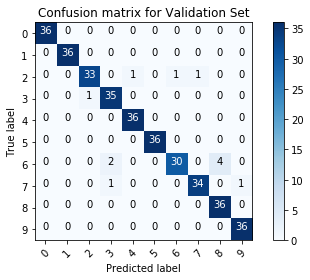

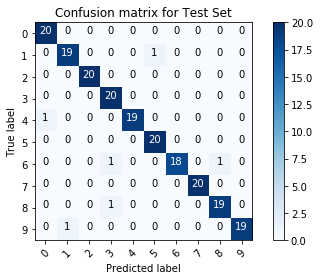

In [11]:
from sklearn.metrics import confusion_matrix

labels = list(range(10))

conf_mat_val = confusion_matrix(y_val, y_pred_val)
plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')
plt.show()

conf_mat_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')
plt.show()

## Βήμα 14
1. Για το `LSTM` έχουμε:

In [84]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn

class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        
        self.lengths = [feat.shape[0] for feat in feats]
        
        self.num_sequences = len(feats)
        self.max_sequence_length = max(lengths)
        self.feature_dimension = feats[0].shape[1]

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        
        padded = np.array([np.pad(feat.reshape(-1),
                            (0, (self.max_sequence_length - length)*self.feature_dimension), 'constant')
                            .reshape(self.max_sequence_length, self.feature_dimension) 
                            for feat, length in zip(x, self.lengths)])
        return padded

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)

In [103]:
inputs = FrameLevelDataset(X_train, y_train.tolist())

In [20]:

class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network

        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()
